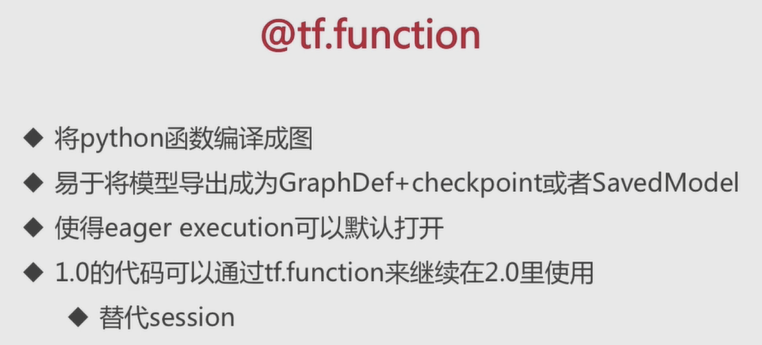

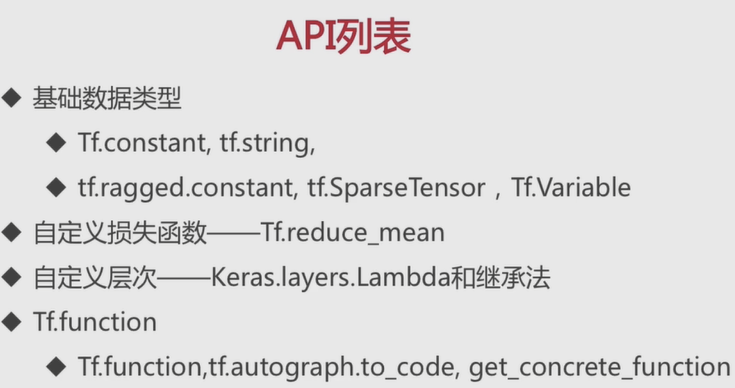

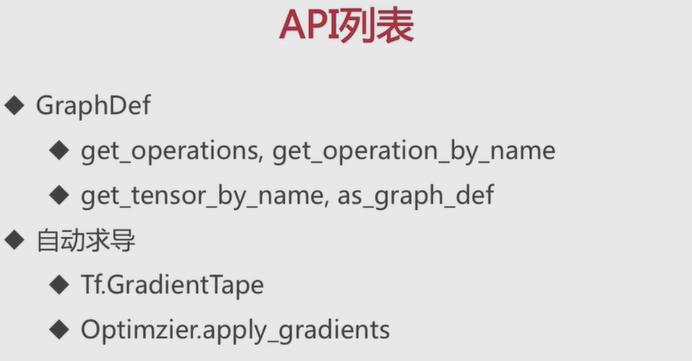

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os, sys, time

import tensorflow as tf
from tensorflow import keras

%matplotlib inline

print(tf.__version__)
print(sys.version_info)

2.0.0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


### constant

In [2]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
print(t)
print(t[:, 1:])
print(t[..., 1])

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[2. 3.]
 [5. 6.]], shape=(2, 2), dtype=float32)
tf.Tensor([2. 5.], shape=(2,), dtype=float32)


In [5]:
print(t + 10)
print(tf.square(t))
print(t @ tf.transpose(t))

tf.Tensor(
[[11. 12. 13.]
 [14. 15. 16.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[ 1.  4.  9.]
 [16. 25. 36.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[14. 32.]
 [32. 77.]], shape=(2, 2), dtype=float32)


In [6]:
print(t.numpy())

[[1. 2. 3.]
 [4. 5. 6.]]


### string

In [7]:
t = tf.constant("tensor")
print(t)
print(tf.strings.length(t))
print(tf.strings.length(t, unit="UTF8_CHAR"))
print(tf.strings.unicode_decode(t, "UTF8"))

tf.Tensor(b'tensor', shape=(), dtype=string)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor([116 101 110 115 111 114], shape=(6,), dtype=int32)


In [8]:
t = tf.constant(["tensor", "flow", "你好"])
print(tf.strings.length(t, unit="UTF8_CHAR"))
r = tf.strings.unicode_decode(t, "UTF8")
print(r)

tf.Tensor([6 4 2], shape=(3,), dtype=int32)
<tf.RaggedTensor [[116, 101, 110, 115, 111, 114], [102, 108, 111, 119], [20320, 22909]]>


### RaggedTensor

RaggedTensor： 不规则的n维矩阵

In [9]:
r = tf.ragged.constant([[11, 12], [21, 22, 23], [], [41]])
print(r)

r2 = tf.ragged.constant([[51, 52], [], [71]])
print(tf.concat([r, r2], axis=0))

<tf.RaggedTensor [[11, 12], [21, 22, 23], [], [41]]>
<tf.RaggedTensor [[11, 12], [21, 22, 23], [], [41], [51, 52], [], [71]]>


In [10]:
print(r.to_tensor())

tf.Tensor(
[[11 12  0]
 [21 22 23]
 [ 0  0  0]
 [41  0  0]], shape=(4, 3), dtype=int32)


### sparse

In [11]:
print(r.to_sparse())

SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]
 [1 2]
 [3 0]], shape=(6, 2), dtype=int64), values=tf.Tensor([11 12 21 22 23 41], shape=(6,), dtype=int32), dense_shape=tf.Tensor([4 3], shape=(2,), dtype=int64))


In [12]:
s = tf.SparseTensor(indices=[[0, 1], [1, 2], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])
print(s)
s = tf.sparse.reorder()
print(tf.sparse.to_dense(s))

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 2]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))
tf.Tensor(
[[0. 1. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 3.]], shape=(3, 4), dtype=float32)


In [17]:
s2 = s * 2.0
print(s2)

try:
    s3 = s + 1
except TypeError as ex:
    print(ex)

s4 = tf.constant([[0., 1.], [1., 2.], [2., 3.], [3., 4.]])
print(tf.sparse.sparse_dense_matmul(s, s4))

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 2]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))
unsupported operand type(s) for +: 'SparseTensor' and 'int'
tf.Tensor(
[[ 1.  2.]
 [ 4.  6.]
 [ 9. 12.]], shape=(3, 2), dtype=float32)


### Variable

In [18]:
v = tf.Variable([[0., 1.], [1., 2.]])
v.assign(2 * v)
print(v.numpy())
v[1].assign([6, 6])
print(v.numpy())

[[0. 2.]
 [2. 4.]]
[[0. 2.]
 [6. 6.]]


### 自定义loss

In [ ]:
def customized_mse(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

# model.compile(loss=customized_mse)

### 自定义Layer

In [ ]:
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name="kernel",
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.bias = self.add_weight(name="bias",
                                    shape=(self.units,),
                                    initializer='zeros',
                                    trainable=True)
        super(CustomizedDenseLayer, self).build(input_shape)

    def call(self, x):
        return self.activation(x @ self.kernel + self.bias)

In [ ]:
# Lambda
customized_softplus = keras.layers.Lambda(lambda x: tf.nn.softplus(x))

### tf.function

转换为静态图

In [19]:
def scaled_elu(z, scale=1.0, alpha=1.0):
    is_positive = tf.greater_equal(z, 0.0)
    return scale * tf.where(is_positive, z, alpha * tf.nn.elu(z))

scaled_elu_tf = tf.function(scaled_elu)

In [22]:
%timeit scaled_elu(tf.random.normal((10000, 10000)))

80.5 ms ± 771 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%timeit scaled_elu_tf(tf.random.normal((10000, 10000)))

77.4 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
scaled_elu_tf.python_function is scaled_elu

True

In [36]:
# 函数签名
@tf.function(input_signature=[tf.TensorSpec([None], tf.int32, name='n_iters')])
def converge_to_two(n_iters):
#     total = tf.constant(0.)
#     increment = tf.constant(1.)
#     for _ in range(n_iters):
#         total += increment
#         increment /= 2.0
#     return total
    return tf.pow(n_iters, 3)


def display_tf_code(func):
    code = tf.autograph.to_code(func)
    from IPython.display import display, Markdown
    display(Markdown('```python\n{}\n```'.format(code)))

In [32]:
display_tf_code(scaled_elu)

```python
def tf__scaled_elu(z, scale=None, alpha=None):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('scaled_elu', 'scaled_elu_scope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as scaled_elu_scope:
    is_positive = ag__.converted_call(tf.greater_equal, scaled_elu_scope.callopts, (z, 0.0), None, scaled_elu_scope)
    do_return = True
    retval_ = scaled_elu_scope.mark_return_value(scale * ag__.converted_call(tf.where, scaled_elu_scope.callopts, (is_positive, z, alpha * ag__.converted_call(tf.nn.elu, scaled_elu_scope.callopts, (z,), None, scaled_elu_scope)), None, scaled_elu_scope))
  do_return,
  return ag__.retval(retval_)

```

In [37]:
# tf.function：转换py func为tf graph
# get_concrete_function：add input signature for SavedModel
converge_to_two_init32 = converge_to_two.get_concrete_function(
    tf.TensorSpec([None], tf.int32))
print(converge_to_two_init32)

In [38]:
converge_to_two_init32.graph

In [39]:
converge_to_two_init32.graph.get_operations()

[<tf.Operation 'n_iters' type=Placeholder>,
 <tf.Operation 'Pow/y' type=Const>,
 <tf.Operation 'Pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [40]:
converge_to_two_init32.graph.as_graph_def()

node {
  name: "n_iters"
  op: "Placeholder"
  attr {
    key: "_user_specified_name"
    value {
      s: "n_iters"
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
node {
  name: "Pow/y"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 3
      }
    }
  }
}
node {
  name: "Pow"
  op: "Pow"
  input: "n_iters"
  input: "Pow/y"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
}
node {
  name: "Identity"
  op: "Identity"
  input: "Pow"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
}
versions {
  producer: 119
}

### 自定义求导

In [3]:
def f(x):
    return 3. * x ** 2. * x -1

def approximate_derivative(f, x, eps=1e-3):
    return (f(x + eps) - f(x - eps)) / (2. * eps)

def g(x1, x2):
    return (x1 + 3) * x2 ** 2

def approximate_gradient(g, x1, x2, eps=1e-3):
    d_x1 = approximate_derivative(lambda x: g(x, x1), x1, eps)
    d_x2 = approximate_derivative(lambda x: g(x1, x), x2, eps)
    return d_x1, d_x2

In [6]:
# 梯度下降
learning_rate = 0.1
x = tf.Variable(1.)
optimizer = keras.optimizers.SGD(lr=learning_rate)

for _ in range(100):
    with tf.GradientTape() as tape:
        z = f(x)
    dz_x = tape.gradient(z, x)
    optimizer.apply_gradients([(dz_x, x)])
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.009879231>


In [7]:
# persistence
x1 = tf.Variable(2.)
x2 = tf.Variable(3.)

with tf.GradientTape(persistent=True) as tape:
    z = g(x1, x2)

dz_x1 = tape.gradient(z, x1)
print(dz_x1)
del tape

tf.Tensor(9.0, shape=(), dtype=float32)


In [ ]:
# 求导嵌入示例
epochs = 100
batch_size = 32
steps_per_epoch = len(x_train) // batch_size
optimizer = keras.optimizers.SGD()
metrics = keras.metrics.MeanSquaredError()

def random_batch(x, y, batch_size=32):
    idx = np.random.randint(0, len(x), size=batch_size)
    return x[idx], y[idx]

model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu',
                       input_shape=x_train.shape[1: ]),
    keras.layers.Dense(1)
])

for epoch in range(epochs):
    metrics.reset_state()
    for step in range(steps_per_epoch):
        x_batch, y_batch = random_batch(x_train, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(x_batch)
            loss = tf.reduce_mean(keras.losses.mean_squared_error(y_batch, y_pred))
            metrics(y_batch, y_pred)
        grads = tape.gradient(loss, model.variables)
        grads_vars = zip(grads, model.variables)
        optimizer.apply_gradients(grads_vars)
        print(epoch, metrics.result().numpy())
    y_valid_pred = model(x_valid)
    valid_loss = tf.reduce_mean(keras.losses.mean_squared_error(y_valid, y_valid_pred))
    print(epoch, metrics.result().numpy())